In [1]:
import asyncio
import logging
import os
import time
import urllib
import warnings

import awkward as ak
import cabinetry
from coffea import processor
from coffea.processor import servicex
from coffea.nanoevents import transforms, NanoEventsFactory
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from func_adl import ObjectStream
import hist
import json
import matplotlib.pyplot as plt
import numpy as np
import uproot

import utils  # contains code for bookkeeping and cosmetics, as well as some boilerplate

logging.basicConfig(format="%(levelname)s - %(name)s - %(message)s")
logging.getLogger("cabinetry").setLevel(logging.INFO)

In [2]:
class AGCSchema(BaseSchema):
    # credit to Mat Adamec for implementing this schema
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])

    def _build_collections(self, branch_forms):
        
        names = set([k.split('_')[0] for k in branch_forms.keys() if not (k.startswith('number'))])
        # Remove n(names) from consideration. It's safe to just remove names that start with n,
        # as nothing else begins with n in our fields.
        # Also remove GenPart, PV and MET because they deviate from the pattern of having a 'number' field.
        names = [k for k in names if not (
                    k.startswith("n") | k.startswith("met") | k.startswith("GenPart") | k.startswith("PV")
        )]
        
        output = {}
        for name in names:
            offsets = transforms.counts2offsets_form(branch_forms['number' + name])
            content = {
                k[len(name) + 1 :]: branch_forms[k]
                for k in branch_forms
                if (k.startswith(name + "_") & (k[len(name) + 1 :] != "e"))
            }
            # Add energy separately so its treated correctly by the p4 vector.
            content['energy'] = branch_forms[name+'_e']
            
            # Check for LorentzVector
            output[name] = zip_forms(content, name, 'PtEtaPhiELorentzVector', offsets=offsets)

        return output

    @property
    def behavior(self):
        behavior = {}
        behavior.update(base.behavior)
        behavior.update(vector.behavior)
        return behavior

In [3]:
class AGCSchema_nanoAOD(BaseSchema):
    # credit to Mat Adamec for implementing this schema
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])

    def _build_collections(self, branch_forms):
        
        names = set([k.split('_')[0] for k in branch_forms.keys()])
        names = [k for k in names if not (k.startswith("n") | 
                                          k.startswith("HTXS") | 
                                          k.startswith("HL") | 
                                          k.startswith("Puppi") | 
                                          k.startswith("Raw") | 
                                          k.startswith("LHE") | 
                                          k.startswith("Soft") |
                                          k.startswith("Gen") |
                                          k.startswith("gen") |
                                          k.startswith("fixed") | 
                                          k.startswith("C") |
                                          k.startswith("D") |
                                          k.startswith("F") |
                                          k.startswith("MET") |
                                          k.startswith("L1") |
                                          k.startswith("PSWeight") | 
                                          k.startswith("PV") | 
                                          k.startswith("Pileup") |
                                          k.startswith("Other") |
                                          k.startswith("TkMET") |
                                          k.startswith("btagWeight") |
                                          k.startswith("lum") |
                                          k.startswith("run") |
                                          k.startswith("event") |
                                          k.startswith("SV"))]
        
        
        output = {}
        for name in names:
            offsets = transforms.counts2offsets_form(branch_forms['n' + name])
            content = {
                k[len(name) + 1 :]: branch_forms[k]
                for k in branch_forms
                if (k.startswith(name + "_") & (not k[len(name) + 1 :] in ["btagCSVV2"]))
            }
            
            if name == "Jet": content['btag'] = branch_forms[name+'_btagCSVV2']
            
            output[name] = zip_forms(content, name, 'PtEtaPhiMLorentzVector', offsets=offsets)

        return output

    @property
    def behavior(self):
        behavior = {}
        behavior.update(base.behavior)
        behavior.update(vector.behavior)
        return behavior

In [8]:
def process_events(filename, storagename, schema, treepath):
    
    if not os.path.exists(storagename):
        urllib.request.urlretrieve(filename, filename=storagename)
        
    f = uproot.open(storagename)
    for key in f[treepath].keys():
        print(key)
    
    events = NanoEventsFactory.from_root(storagename, schemaclass=schema, treepath=treepath).events()
    
    return events

In [9]:
def get_top_mass(events):
    
    # pT > 25 GeV for leptons & jets    
    selected_electrons = events.Electron[events.Electron.pt > 25]
    selected_muons = events.Muon[events.Muon.pt > 25]
    selected_jets = events.Jet[events.Jet.pt > 25]

    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 0.5
    event_filters = event_filters & (ak.sum(selected_jets.btag > B_TAG_THRESHOLD, axis=1) >= 2)

    # apply filters
    selected_jets = selected_jets[event_filters]

    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system

    trijet["max_btag"] = np.maximum(trijet.j1.btag, np.maximum(trijet.j2.btag, trijet.j3.btag))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # require at least one-btag in trijet candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    reconstructed_top_mass = ak.flatten(trijet_mass) 
    
    return reconstructed_top_mass

In [10]:
events_tt = process_events("https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0005.root",
                           "ttbar.root",
                           AGCSchema_nanoAOD,
                           "Events")

# events_sc = process_events("https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/ST_s-channel_4f_InclusiveDecays_13TeV-amcatnlo-pythia8/cmsopendata2015_single_top_s_chan_19394_PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1_70000_0000.root",
#                            "schannel.root",
#                            AGCSchema_nanoAOD,
#                            "Events")

# events_tc = process_events("https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/ST_t-channel_antitop_4f_inclusiveDecays_13TeV-powhegV2-madspin-pythia8_TuneCUETP8M1/cmsopendata2015_single_top_t_chan_19406_PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1_00000_0009.root",
#                            "tchannel.root",
#                            AGCSchema_nanoAOD,
#                            "Events")

# events_tw = process_events("https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/ST_tW_antitop_5f_inclusiveDecays_13TeV-powheg-pythia8_TuneCUETP8M1/cmsopendata2015_single_top_tW_19412_PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1_20000_0000.root",
#                            "tw.root",
#                            AGCSchema_nanoAOD,
#                            "Events")

# events_wj = process_events("https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/cmsopendata2015_wjets_20548_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext4-v1_80000_0025.root",
#                            "wjet.root",
#                            AGCSchema_nanoAOD,
#                            "Events")

run
luminosityBlock
event
HTXS_Higgs_pt
HTXS_Higgs_y
HTXS_stage1_1_cat_pTjet25GeV
HTXS_stage1_1_cat_pTjet30GeV
HTXS_stage1_1_fine_cat_pTjet25GeV
HTXS_stage1_1_fine_cat_pTjet30GeV
HTXS_stage1_2_cat_pTjet25GeV
HTXS_stage1_2_cat_pTjet30GeV
HTXS_stage1_2_fine_cat_pTjet25GeV
HTXS_stage1_2_fine_cat_pTjet30GeV
HTXS_stage_0
HTXS_stage_1_pTjet25
HTXS_stage_1_pTjet30
HTXS_njets25
HTXS_njets30
btagWeight_CSVV2
btagWeight_DeepCSVB
CaloMET_phi
CaloMET_pt
CaloMET_sumEt
ChsMET_phi
ChsMET_pt
ChsMET_sumEt
nCorrT1METJet
CorrT1METJet_area
CorrT1METJet_eta
CorrT1METJet_muonSubtrFactor
CorrT1METJet_phi
CorrT1METJet_rawPt
DeepMETResolutionTune_phi
DeepMETResolutionTune_pt
DeepMETResponseTune_phi
DeepMETResponseTune_pt
nElectron
Electron_deltaEtaSC
Electron_dr03EcalRecHitSumEt
Electron_dr03HcalDepth1TowerSumEt
Electron_dr03TkSumPt
Electron_dr03TkSumPtHEEP
Electron_dxy
Electron_dxyErr
Electron_dz
Electron_dzErr
Electron_eInvMinusPInv
Electron_energyErr
Electron_eta
Electron_hoe
Electron_ip3d
Electron_jetPtRel

In [20]:
events_wj.metadata

{}

In [19]:
topmass_tt = get_top_mass(events_tt)
topmass_sc = get_top_mass(events_sc)
topmass_tc = get_top_mass(events_tc)
topmass_tw = get_top_mass(events_tw)
topmass_wj = get_top_mass(events_wj)

In [ ]:
topmass_hist = (hist.Hist.new.Reg(num_bins, bin_low, bin_high, name=name, label=label)
                .StrCat([], name="process", label="Process", growth=True)
                .Weight()
               )

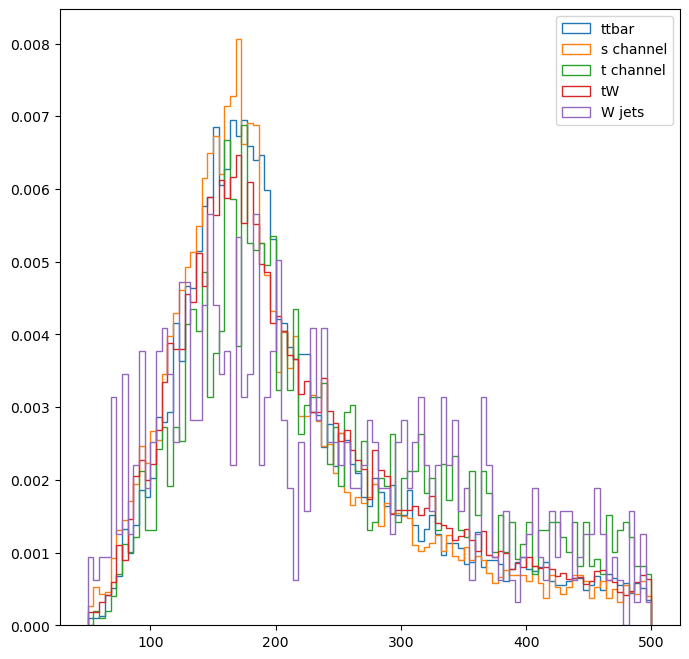

In [11]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
bins = np.linspace(50,500,100)
ax.hist(topmass_tt, bins=bins, histtype='step', density=True)
ax.hist(topmass_sc, bins=bins, histtype='step', density=True)
ax.hist(topmass_tc, bins=bins, histtype='step', density=True)
ax.hist(topmass_tw, bins=bins, histtype='step', density=True)
ax.hist(topmass_wj, bins=bins, histtype='step', density=True)
ax.legend(["ttbar","s channel","t channel","tW","W jets"])
plt.show()